Проект: Исследование рынка заведений общественного питания Москвы
==

## Изучение общей информации о датасете

In [1]:
# Здесь будут все импортируемые библиотеки

import pandas as pd
import re # для добавления столбца с улицами
import numpy as np

! pip install -U kaleido

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from plotly import graph_objects as go 
from plotly.offline import plot
import plotly.express as px
import seaborn as sns

# библиотеку для хороплета
import folium
from folium import Marker, Map
# кластер
from folium.plugins import MarkerCluster
# модуль для работы с JSON-форматом
import json

import warnings
warnings.simplefilter('ignore')

In [2]:
# Загружаю датасет

data = pd.read_csv('/datasets/moscow_places.csv')

In [3]:
data.head(3)

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN
1,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0
2,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


**Вывод**

В датасете представлено 8406 заведений. Вид датасета соответствует правилам хорошего тона.

Содержит 14 столбцов:
1. "name" - название заведения
2. "category" - категория заведения
3. "address" - адрес заведения
4. "district" - административный район, в котором находится заведение
5. "hours" - информация о днях и часах работы заведения
6. "lat" - широта географической точки, в которой находится заведение
7. "lng" - долгота географической точки, в которой находится заведение
8. "rating" - рейтинг заведения по оценкам пользователей в "Яндекс Картах"
9. "price" - категория цен в заведении
10. "avg_bill" - средняя стоимость заказа, диапазон
11. "middle_avg_bill" - число с оценкой среднего чека
12. "middle_coffee_cup" - число с оценкой стоимости одной чашки капучино
13. "chain" - является ли заведение сетевым
14. "seats" - количество посадочных мест в заведении

В столбце "seats" тип данных дробное число, в предобработке я его изменю на целочисленный, ведь количество посадочных мест не может быть дробным числом. В остальном, типы логически верные.

## Предобработка данных

In [5]:
# Проверю дубликаты

data.duplicated().sum()

0

In [6]:
# Поищу неявные дубликаты в названиях заведений

display(data['name'].nunique())

# Приведу все названия заведений к нижнему регистру, удалю пробелы, заменю ё на е

data['name'] = data['name'].str.lower()
data['name'] = data['name'].str.strip()
data['name'] = data['name'].str.replace('ё', 'е')

display(data['name'].nunique())

5614

5506

In [7]:
# Поищу неявные дубликаты в адресах заведений

display(data['address'].nunique())

# Приведу все адреса заведений к нижнему регистру, удалю пробелы, заменю ё на е

data['address'] = data['address'].str.lower()
data['address'] = data['address'].str.strip()
data['address'] = data['address'].str.replace('ё', 'е')

display(data['name'].nunique())

5753

5506

In [8]:
# Посмотрю, что с дубликатами теперь 

data[['name', 'address']].duplicated().sum()

4

In [9]:
# Найдено 4 дубликата, совпадающих в названиях и адресах. Удалю их

data[['name', 'address']] = data[['name', 'address']].drop_duplicates()

data = data.dropna(subset=['name', 'address'])


data[['name', 'address']].duplicated().sum()

0

In [10]:
# Проверю по количеству оставшихся строк

data.shape[0]

# Все верно, 4 удалено

8402

In [11]:
# Проверю пропуски

data.isna().sum()

name                    0
category                0
address                 0
district                0
hours                 535
lat                     0
lng                     0
rating                  0
price                5087
avg_bill             4586
middle_avg_bill      5253
middle_coffee_cup    7867
chain                   0
seats                3610
dtype: int64

In [12]:
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')

,0
name,0.000000
category,0.000000
address,0.000000
district,0.000000
hours,6.370000
lat,0.000000
lng,0.000000
rating,0.000000
price,60.550000
avg_bill,54.580000


Есть пропуски. Почти весь столбец 'middle_coffee_cup' с пропусками - почти 94%. Однако, заменить логически их нечем, я оставлю всё так, как есть.

In [13]:
# В столбце "seats" есть пропуски, изменю тип данных вот так

data['seats'] = data['seats'].convert_dtypes()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8402 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8402 non-null   object 
 1   category           8402 non-null   object 
 2   address            8402 non-null   object 
 3   district           8402 non-null   object 
 4   hours              7867 non-null   object 
 5   lat                8402 non-null   float64
 6   lng                8402 non-null   float64
 7   rating             8402 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8402 non-null   int64  
 13  seats              4792 non-null   Int64  
dtypes: Int64(1), float64(5), int64(1), object(7)
memory usage: 992.8+ KB


In [15]:
# Добавлю столбец с улицами

words = ['улица','ул']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

data['street'] = data['address'].str.extract(str_pat, flags=re.I)

In [16]:
# Проверю, все ли корректно

data[['address', 'street']].head()

,address,street
0,"москва, улица дыбенко, 7/1",улица дыбенко
1,"москва, улица дыбенко, 36, корп. 1",улица дыбенко
2,"москва, клязьминская улица, 15",клязьминская улица
3,"москва, улица маршала федоренко, 12",улица маршала федоренко
4,"москва, правобережная улица, 1б",правобережная улица


In [17]:
# Добавлю столбец с круглосуточой работой заведения, да или нет

data['is_24/7'] = np.where(data['hours']=='ежедневно, круглосуточно', 'True', 'False')

In [18]:
# Проверю на корректность работы

data['is_24/7'].value_counts()

False    7672
True      730
Name: is_24/7, dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8402 entries, 0 to 8405
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8402 non-null   object 
 1   category           8402 non-null   object 
 2   address            8402 non-null   object 
 3   district           8402 non-null   object 
 4   hours              7867 non-null   object 
 5   lat                8402 non-null   float64
 6   lng                8402 non-null   float64
 7   rating             8402 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8402 non-null   int64  
 13  seats              4792 non-null   Int64  
 14  street             4929 non-null   object 
 15  is_24/7            8402 non-null   object 
dtypes: Int64(1), float64(5),

In [20]:
# Тип получился object, изменю его на bool

data['is_24/7'] = (data['is_24/7']=='True').astype(bool)


In [21]:
# Проверю, что True и False не потерялись в количестве

data['is_24/7'].value_counts()

False    7672
True      730
Name: is_24/7, dtype: int64

In [22]:
data.info()

# Все верно, тип bool

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8402 entries, 0 to 8405
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8402 non-null   object 
 1   category           8402 non-null   object 
 2   address            8402 non-null   object 
 3   district           8402 non-null   object 
 4   hours              7867 non-null   object 
 5   lat                8402 non-null   float64
 6   lng                8402 non-null   float64
 7   rating             8402 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8402 non-null   int64  
 13  seats              4792 non-null   Int64  
 14  street             4929 non-null   object 
 15  is_24/7            8402 non-null   bool   
dtypes: Int64(1), bool(1), fl

**Вывод**

Я провела предобработку данных:
1. Было выявлено 4 дубликата в названии-адресе, я от них избавилась.
2. В датасете есть пропуски в столбцах:
- hours - 535 шт
- price - 5087 шт
- avg_bill - 4586 шт
- middle_avg_bill - 5253 шт
- middle_coffee_cup - 7867 шт
- seats - 3610 шт

Я решила их оставить, тк заменить логически пропуски нечем, удалять смысла нет.

3. Добавила два столбца в датасет:
- data['street'] - с названием улиц из адреса заведения
- data['is_24/7'] - с логическими значениями: True - работает круглосуточно, False - нет

Данные готовы, можно приступать к дальнейшим шагам по плану.

## Анализ данных

Приступаю к изучению рынка заведений общественного питания Москвы.

### Изучение категорий заведений

In [23]:
# Посмотрю, какие есть категории и количество заведений в них

data['category'].value_counts()

кафе               2376
ресторан           2042
кофейня            1413
бар,паб             764
пиццерия            633
быстрое питание     603
столовая            315
булочная            256
Name: category, dtype: int64

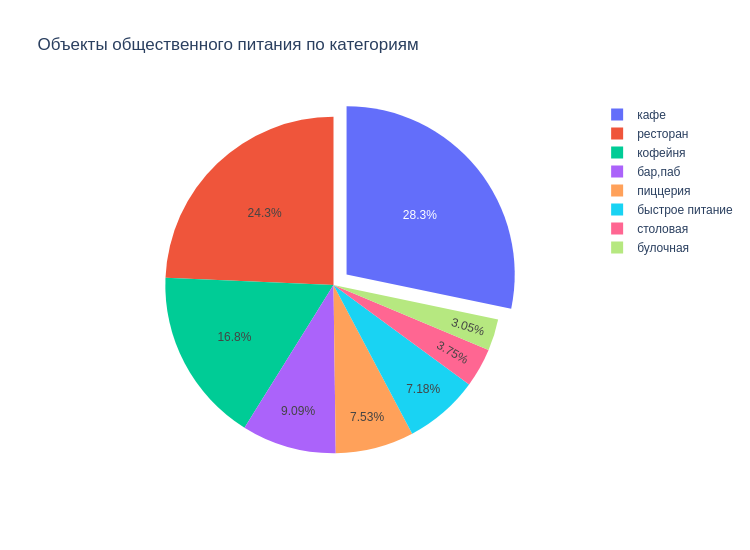

In [24]:
# Для наглядности график

fig = go.Figure(data=[go.Pie(labels=data['category'], pull = [0.1, 0])])

fig.update_layout(title='Объекты общественного питания по категориям', # указываю заголовок графика
                  width=750, # указываю размеры графика
                  height=550)
fig.show("png") 

**Вывод**

Всего есть 8 категорий заведений. По количеству заведений, категории располагаются так: 
- кафе - доля 28.3%
- ресторан - 24.3%
- кофейня - 16.8%
- бар/паб - 9.09%
- пиццерия - 7.53%
- быстрое питание - 7.18%
- столовая - 3.75%
- булочная - 3.05%

### Исследование количества посадочных мест в местах по категориям

In [25]:
# Сначала посмотрю на общую картину посадочных мест

data['seats'].describe()

count    4792.000000
mean      108.361436
std       122.841130
min         0.000000
25%        40.000000
50%        75.000000
75%       140.000000
max      1288.000000
Name: seats, dtype: float64

In [26]:
# Возьму медианные значения

data_seats_m = data.groupby('category')['seats'].median().sort_values(ascending=False).reset_index()
data_seats_m

,category,seats
0,ресторан,86.0
1,"бар,паб",82.0
2,кофейня,80.0
3,столовая,75.5
4,быстрое питание,65.0
5,кафе,60.0
6,пиццерия,55.0
7,булочная,50.0


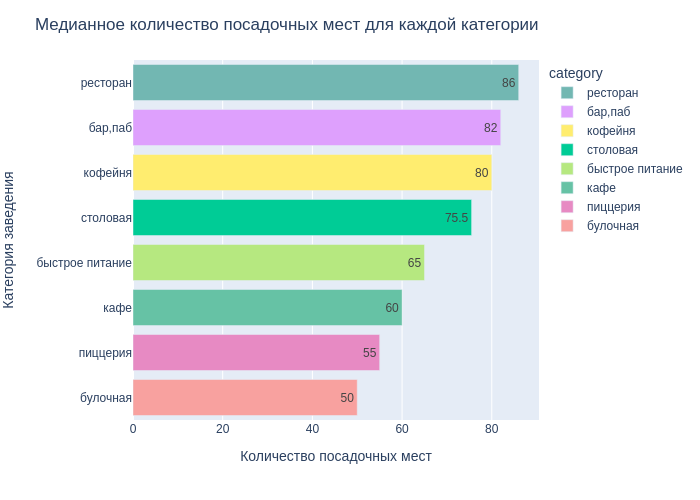

In [27]:
# строю столбчатую диаграмму 

fig = px.bar(data_seats_m.sort_values(by='seats', ascending=False), # загружаю данные и заново их сортирую
             x='seats', # столбец с данными для оси X
             y='category', # столбец с данными для оси Y
             text='seats', # добавляю аргумент, который отобразит текст с информацией
             color='category',
             color_discrete_sequence=[
                 px.colors.qualitative.T10[3],
                 px.colors.qualitative.Alphabet[11], 
               px.colors.qualitative.Set3[11],
               px.colors.qualitative.Plotly[2],
                 px.colors.qualitative.Plotly[7],
                 px.colors.qualitative.Set2[0],
                 px.colors.qualitative.Set2[3],
                 px.colors.qualitative.Alphabet[15]]                   
            )
# оформляю график
fig.update_layout(title='Медианное количество посадочных мест для каждой категории',
                   xaxis_title='Количество посадочных мест',
                   yaxis_title='Категория заведения')
fig.show("png")

Смотреть общее количество мест или среднее не логично, данная информация нам ничего не даст. Поэтому, я смотрю в разрезе медианы, чтоб отбросить аномальные значения.

Лидируют рестораны, затем бары/пабы, на третьем месте по количеству посадочных мест кофейни.

**Вывод**

Медианное количество посадочных мест: 
- ресторан	- 86
- бар,паб	- 82
- кофейня	- 80
- столовая	- 75
- быстрое питание	- 65
- кафе	- 60
- пиццерия	- 55
- булочная	- 50

Есть объекты и с более 1200 посадочных мест. В целом же, количество мест до 400.


### Изучение сетевых и несетевых заведений

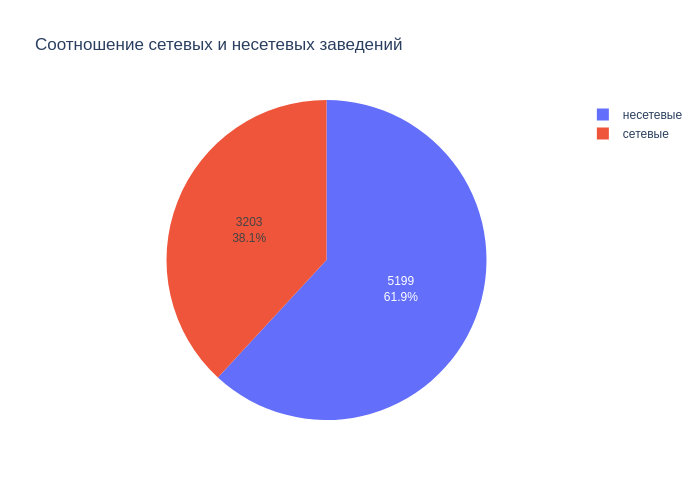

In [28]:
# Посмотрю соотношение сетевых и несетевых заведений в датасете
# Изменю для легенды 0 и 1 на слова

data['chain_tex'] = data['chain']
data['chain_tex'] = data['chain_tex'].apply(lambda x: 'несетевые' if x==0 else 'сетевые')

# Строю график

fig = go.Figure(data=[go.Pie(labels=data['chain_tex'], text=data['chain_tex'], textinfo='value+percent')])

fig.update_layout(title='Соотношение сетевых и несетевых заведений',
                  width=700, 
                  height=500)


fig.show("png") 

In [29]:
# Теперь посмотрю в разрезе по категориям

network = data.pivot_table(index='category', columns='chain', values='name', aggfunc='count').reset_index()
network['total'] = network[0]+network[1]
network['persent_set'] = round(network[1]/network['total']*100)
network = network.sort_values(by='persent_set', ascending=False)
network

chain,category,0,1,total,persent_set
1,булочная,99,157,256,61.0
5,пиццерия,303,330,633,52.0
4,кофейня,693,720,1413,51.0
2,быстрое питание,371,232,603,38.0
6,ресторан,1313,729,2042,36.0
3,кафе,1597,779,2376,33.0
7,столовая,227,88,315,28.0
0,"бар,паб",596,168,764,22.0


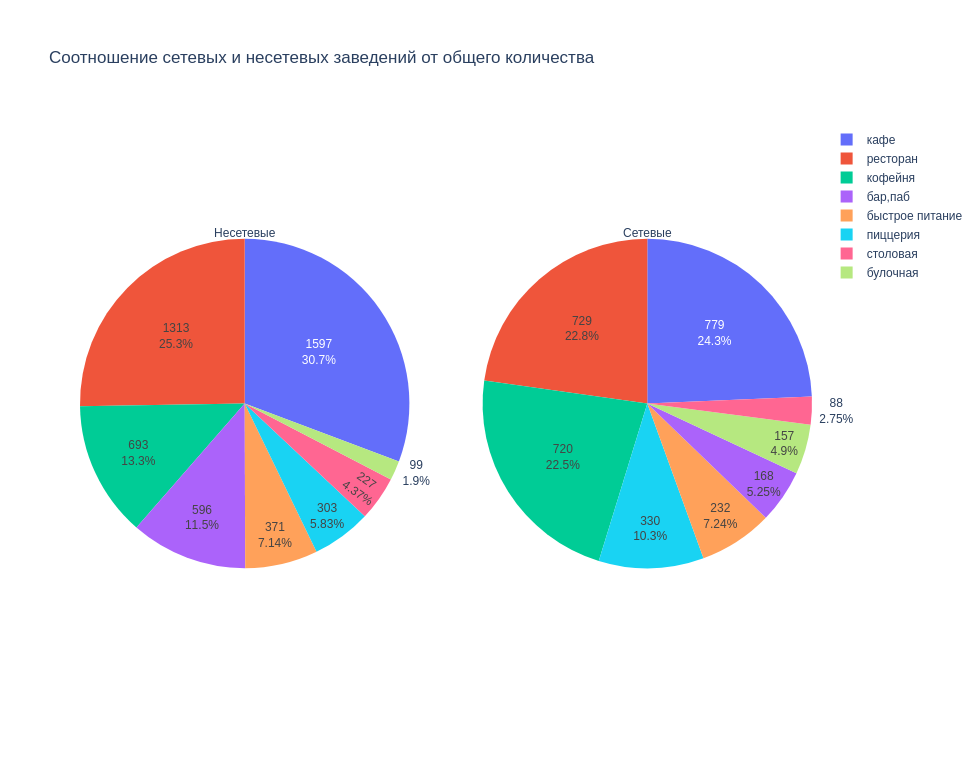

In [30]:
# Соотношение сетевых и несетевых заведений в разрезе по категориям

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])


fig.add_trace(go.Pie(labels=network['category'], values=network[0], textinfo='value+percent', title='Несетевые'), 
     row=1, col=1)

fig.add_trace(go.Pie(labels=network['category'], values=network[1], textinfo='value+percent', title='Сетевые'),
    row=1, col=2)
fig.update_layout(title='Соотношение сетевых и несетевых заведений от общего количества', # указываю заголовок графика
                  width=980, # указываю размеры графика
                  height=780)
plot(fig)
fig.show("png") 

**Вывод**

В представленном датасете преобладают несетевые заведения: 5199 штук (61.9%) против сетевых: 3203 штуки (38.1%).

Кафе, рестораны и кофейни лидеры по количеству и в несетевых, и в сетевых заведениях. 

### Какие категории заведений чаще являются сетевыми

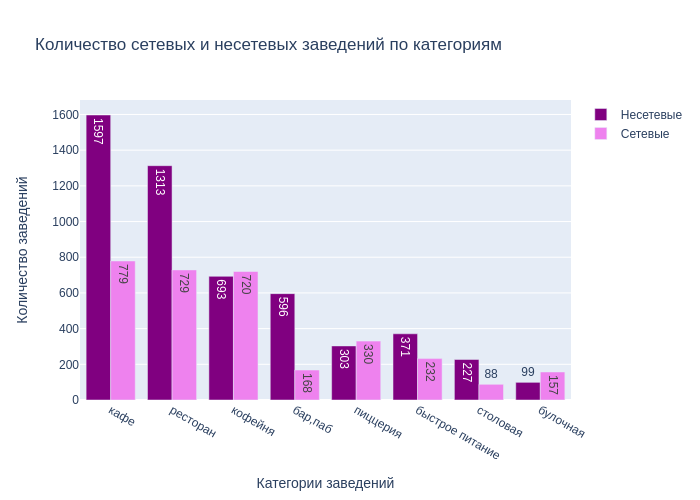

In [31]:
# График количества сетевых и несетевых заведений в разрезе по категориям

network = network.sort_values(by='total', ascending=False) # для красивой сортировки на графике

fig = go.Figure()
fig.add_trace(go.Bar(marker_color= 'purple', name="Несетевые", x = network['category'], y = network[0], text=network[0]))
fig.add_trace(go.Bar(marker_color= 'violet', name="Сетевые", x = network['category'], y = network[1], text=network[1]))

fig.update_layout(title='Количество сетевых и несетевых заведений по категориям',
                   xaxis_title='Категории заведений',
                   yaxis_title='Количество заведений')

fig.show("png")

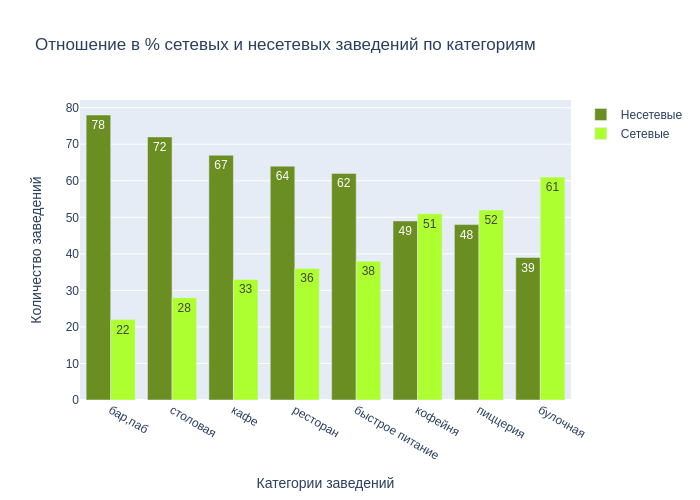

In [32]:
# График отношения сетевых и несетевых заведений в разрезе по категориям

network['persent_no'] = round(network[0]/network['total']*100) # столбец с % несетевых

network = network.sort_values(by='persent_no', ascending=False) # для красивой сортировки на графике

fig = go.Figure()
fig.add_trace(go.Bar(
    marker_color= 'olivedrab', 
    name="Несетевые", 
    x = network['category'], 
    y = network['persent_no'], 
    text=network['persent_no'])
)
fig.add_trace(go.Bar(
    marker_color= 'greenyellow', 
    name="Сетевые", 
    x = network['category'], 
    y = network['persent_set'], 
    text=network['persent_set'])
)

fig.update_layout(title='Отношение в % сетевых и несетевых заведений по категориям',
                   xaxis_title='Категории заведений',
                   yaxis_title='Количество заведений')

fig.show("png")

**Вывод**

Преобладание несетевых заведений к сетевым ярче всего выражено у категории бар/паб (78% несетевых), столовых (72% несетевых), кафе (67% несетевых), ресторанов (64% несетевых) и заведений быстрого питания (62% несетевых).

Сетевых заведений больше у кофеен (51%), пиццерий (52%) и у булочных (61% сетевых заведений).

### Топ-15 популярных сетей в Москве

In [33]:
# Для начала почищу столбец data['name'] от объектов без собственного названия

data_a = data.loc[(data['name']!= 'кафе') & (data['name']!= 'ресторан') & (data['name']!= 'шаурма')]

# Строю таблицу топ 15, количество посчитаю по столбцу с адресом

data_top = data_a.pivot_table(index=['name','category'], values='address', aggfunc='count')
data_top = data_top.sort_values(by='address', ascending=False).iloc[0:15].reset_index()
data_top = data_top.rename(columns={'address':'count'})
data_top

,name,category,count
0,шоколадница,кофейня,119
1,домино'с пицца,пиццерия,77
2,додо пицца,пиццерия,74
3,one price coffee,кофейня,72
4,яндекс лавка,ресторан,69
5,cofix,кофейня,65
6,prime,ресторан,49
7,кофепорт,кофейня,42
8,кулинарная лавка братьев караваевых,кафе,39
9,теремок,ресторан,36


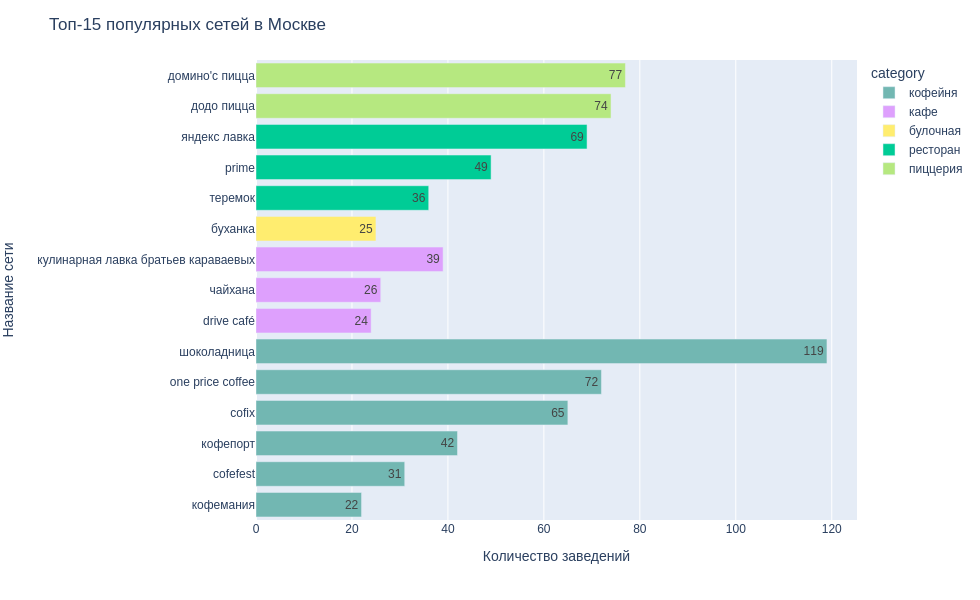

In [34]:
# строю столбчатую диаграмму 

fig = px.bar(data_top.sort_values(by='count', ascending=True), # загружаю данные и заново их сортирую
             x='count', # столбец с данными для оси X
             y='name', # столбец с данными для оси Y
             text='count', # добавляю аргумент, который отобразит текст с информацией
             color='category',
             width=980,
             height=600,
             color_discrete_sequence=[
                 px.colors.qualitative.T10[3],
                 px.colors.qualitative.Alphabet[11], 
               px.colors.qualitative.Set3[11],
               px.colors.qualitative.Plotly[2],
                 px.colors.qualitative.Plotly[7],
                 px.colors.qualitative.Set2[0],
                 px.colors.qualitative.Set2[3],
                 px.colors.qualitative.Alphabet[15]]                   
            )
# оформляю график
fig.update_layout(title='Топ-15 популярных сетей в Москве',
                  xaxis_title='Количество заведений',
                   yaxis_title='Название сети')
fig.update_traces(showlegend=True)
fig.show("png")

**Вывод**

Самыми популярными заведениями Москвы являются:
- шоколадница - 119 шт
- домино'с пицца -77 шт
- додо пицца - 74 шт
- one price coffee - 72 шт
- яндекс лавка - 69 шт
- cofix	- 65 шт
- prime	- 49 шт
- кофепорт - 42 шт
- кулинарная лавка братьев караваевых - 39 шт
- теремок - 36 шт
- cofefest - 31 шт
- чайхана - 26 шт
- буханка - 25 шт
- drive café - 24 шт
- кофемания	- 22 шт

По категориям: 6 кофеен, 3 ресторана, 3 кафе, 2 пиццерии и 1 булочная.

### Заведения по административным районам Москвы

In [35]:
# Сделаю сводную таблицу

data_district = data.pivot_table(index='district', columns='category', values='name', aggfunc='count').reset_index()
data_district['total'] = (
    data_district['бар,паб']+data_district['булочная']
    +data_district['быстрое питание']+data_district['кафе']
    +data_district['кофейня']+data_district['пиццерия']
    +data_district['ресторан']+data_district['столовая']
)
data_district.sort_values(by='total', ascending=False)

category,district,"бар,паб",булочная,быстрое питание,кафе,кофейня,пиццерия,ресторан,столовая,total
5,Центральный административный округ,364,50,87,464,428,113,670,66,2242
2,Северный административный округ,68,39,58,234,193,77,188,41,898
8,Южный административный округ,68,25,85,264,131,73,202,44,892
3,Северо-Восточный административный округ,62,28,82,269,159,68,182,40,890
1,Западный административный округ,50,37,62,238,150,71,218,24,850
0,Восточный административный округ,53,25,71,272,105,72,160,40,798
6,Юго-Восточный административный округ,38,13,67,282,89,55,145,25,714
7,Юго-Западный административный округ,38,27,61,238,96,64,168,17,709
4,Северо-Западный административный округ,23,12,30,115,62,40,109,18,409


In [36]:
# Построю график

district_count = data.groupby(['district', 'category'])['name'].agg({'count'}).sort_values(by='count', ascending=False).reset_index()
district_count.head()

,district,category,count
0,Центральный административный округ,ресторан,670
1,Центральный административный округ,кафе,464
2,Центральный административный округ,кофейня,428
3,Центральный административный округ,"бар,паб",364
4,Юго-Восточный административный округ,кафе,282


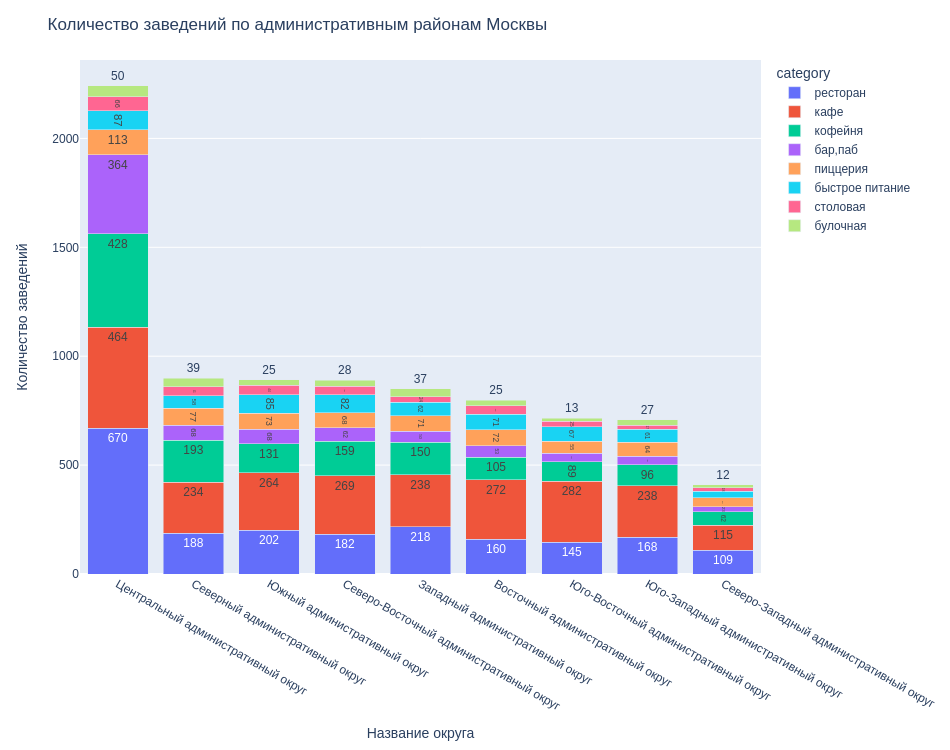

In [37]:
fig = px.bar(
    district_count,
    x='district',
    y='count', 
    width=950, 
    height=750, 
    color='category',
    text='count'
)

fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Количество заведений по административным районам Москвы',
    xaxis_title='Название округа',
    yaxis_title='Количество заведений',
    barmode='stack',
    xaxis={'categoryorder':'total descending',
          'categoryarray':['кафе','ресторан','кофейня','пиццерия','бар,паб','быстрое питание','булочная','столовая']}
)

fig.show("png")

**Вывод**

В датасете представлены 9 административных округов:
- Центральный
- Северный
- Южный
- Северо-Восточный
- Западный
- Восточный
- Юго-Восточный
- Юго-Западный
- Северо-Западный

Больше всего заведений в Центральном административном округе, а меньше всего в Северо-Западном.

### Средние рейтинги по категориям заведений

In [38]:
# Подготовлю данные

data_mean = data.groupby('category')['rating'].agg({'mean'}).sort_values(by='mean', ascending=False).reset_index()
data_mean

,category,mean
0,"бар,паб",4.387696
1,пиццерия,4.301264
2,ресторан,4.290402
3,кофейня,4.277282
4,булочная,4.268359
5,столовая,4.211429
6,кафе,4.124285
7,быстрое питание,4.050249


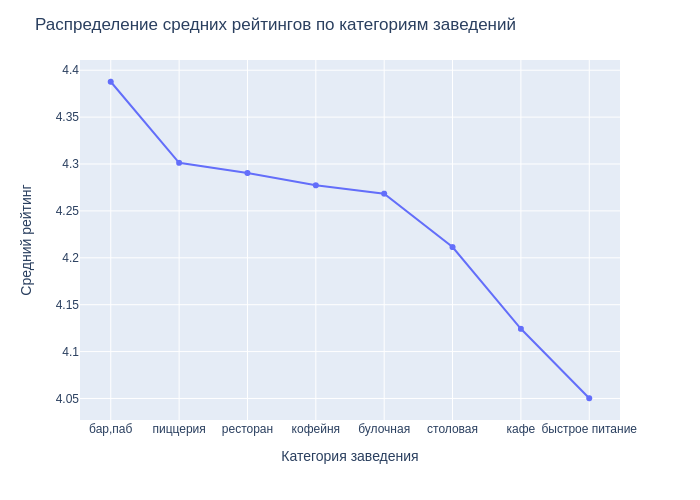

In [39]:
# График

fig = px.line(data_mean, # загружаем данные
              x='category', # указываем столбец с данными для оси X
              y='mean',# обозначаем категорию для разделения цветом
              markers=True) # отображаем маркеры (точки) на графике

fig.update_layout(title='Распределение средних рейтингов по категориям заведений',
                   xaxis_title='Категория заведения',
                   yaxis_title='Средний рейтинг')
fig.show("png") 

**Вывод**

Средний рейтинг заведений по категориям находится в промежутке от 4.05 до 4.39 и распределяется следующим образом:

- бар,паб	- 4.388
- пиццерия	- 4.301
- ресторан	- 4.290
- кофейня	- 4.277
- булочная	- 4.268
- столовая	- 4.211
- кафе	    - 4.124
- быстрое питание	- 4.050

### Фоновая картограмма (хороплет) со средним рейтингом заведений каждого района

In [40]:
# Подготовлю данные

data_rating = data.groupby(['district'])['rating'].agg({'mean'}).sort_values(by='mean', ascending=False).reset_index()
data_rating
    

,district,mean
0,Центральный административный округ,4.377520
1,Северный административный округ,4.240980
2,Северо-Западный административный округ,4.208802
3,Южный административный округ,4.184417
4,Западный административный округ,4.181647
5,Восточный административный округ,4.174185
6,Юго-Западный административный округ,4.172920
7,Северо-Восточный административный округ,4.147978
8,Юго-Восточный административный округ,4.101120


In [41]:
# Функция для создания хороплета

def display_map(dataframe, value, title):
    with open('/datasets/admin_level_geomap.geojson', 'r') as f:
        geo_json = json.load(f)

    loc = title
    title_html = '''<h3 align="center" style="font-size:20px"><b>{}</b></h3>'''.format(loc)
    moscow_lat, moscow_lng = 55.751244, 37.618423
    m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)    
    choropleth = folium.Choropleth(
                    geo_data=geo_json,
                    data=dataframe,
                    columns=['district', value],
                    key_on='feature.name',
                    fill_color='PuRd',
                    fill_opacity=0.8,
                    legend_name=title,
            ).add_to(m)

    # при наведении на округ показывает название округа
    choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields=['name'],
                                    aliases=['округ:'],
                                    labels=True,
                                    localize=True,
                                    sticky=False,
                                    )
    )
    
    m.get_root().html.add_child(folium.Element(title_html))
    m.save('image.html')
    return m

In [42]:
# display_map(data_rating, 'mean', 'Средний рейтинг заведений по районам')

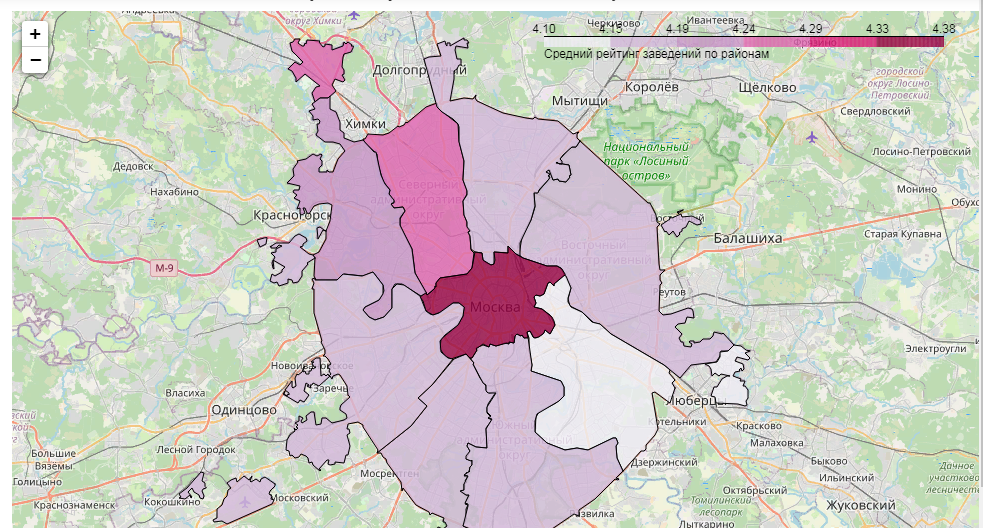

**Вывод**

Средний рейтинг заведений по районам распределяется так:
- Центральный административный округ - 4.37
- Северный административный округ - 4.24
- Северо-Западный административный округ - 4.21
- Южный административный округ - 4.18
- Западный административный округ - 4.18
- Восточный административный округ - 4.17
- Юго-Западный административный округ - 4.17
- Северо-Восточный административный округ - 4.15
- Юго-Восточный административный округ - 4.10

###  Все заведения датасета на карте

In [43]:
# Строю хороплет с кластерами

# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423
# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)
# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
#data.apply(create_clusters, axis=1)
# m

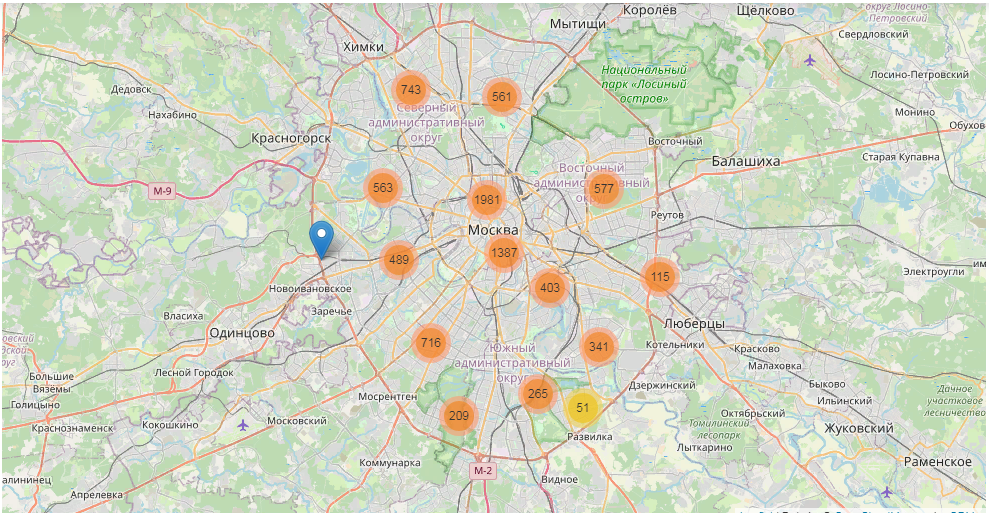

### Топ-15 улиц по количеству заведений

In [44]:
# Найду топ-15 улиц

data_st = data.groupby(['street'])['name'].agg({'count'}).sort_values('count', ascending=False).reset_index()
data_street = data_st.head(15)
data_street

,street,count
0,профсоюзная улица,122
1,люблинская улица,60
2,улица вавилова,55
3,улица миклухо-маклая,49
4,пятницкая улица,48
5,улица арбат,40
6,улица покровка,40
7,новодмитровская улица,40
8,ярцевская улица,37
9,новослободская улица,36


In [45]:
# Теперь подготовлю таблицу для графика

data_street_2 = data.pivot_table(index=['street', 'category'], values='name', aggfunc='count')
data_street_2 = data_street_2.sort_values(['street']).reset_index()
data_street_2 = data_street_2.loc[(
    (data_street_2['street']== 'профсоюзная улица') + 
    (data_street_2['street']== 'люблинская улица') +
    (data_street_2['street']== 'улица вавилова') +
    (data_street_2['street']== 'улица миклухо-маклая') +
    (data_street_2['street']== 'пятницкая улица') +
    (data_street_2['street']== 'улица арбат') +
    (data_street_2['street']== 'улица покровка') +
    (data_street_2['street']== 'новодмитровская улица') +
    (data_street_2['street']== 'ярцевская улица') +
    (data_street_2['street']== 'новослободская улица') +
    (data_street_2['street']== 'лесная улица') +
    (data_street_2['street']== 'усачева улица') +
    (data_street_2['street']== 'краснобогатырская улица') +
    (data_street_2['street']== 'улица ленинская слобода') +
    (data_street_2['street']== 'улица земляной вал')
)]
data_street_2 = data_street_2.rename(columns={'name':'count'})
data_street_2.head(9)

,street,category,count
637,краснобогатырская улица,пиццерия,1
638,краснобогатырская улица,ресторан,11
639,краснобогатырская улица,кофейня,4
640,краснобогатырская улица,"бар,паб",3
641,краснобогатырская улица,быстрое питание,2
642,краснобогатырская улица,булочная,1
643,краснобогатырская улица,кафе,11
690,лесная улица,ресторан,16
691,лесная улица,кафе,10


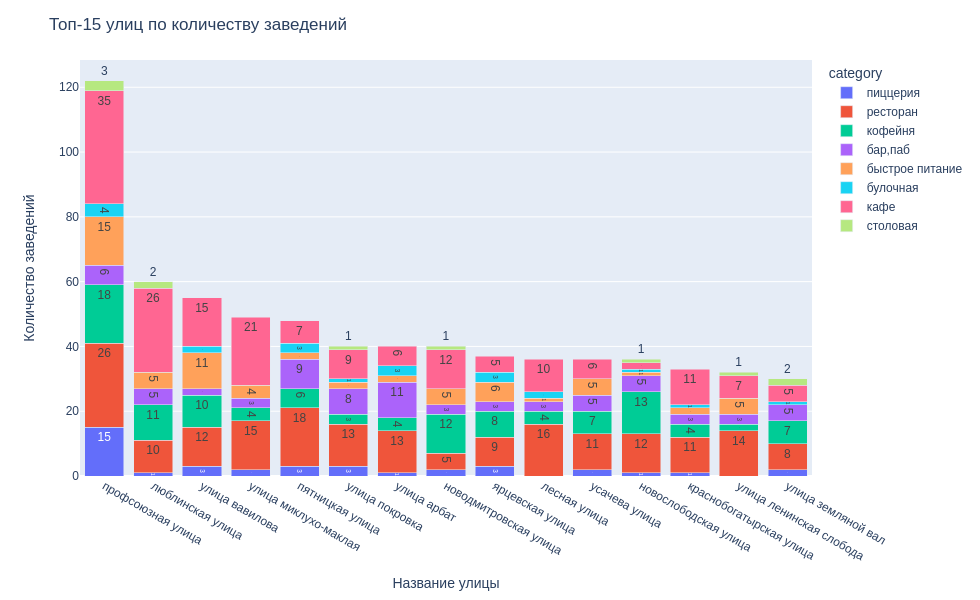

In [46]:
fig = px.bar(
    data_street_2,
    x='street',
    y='count', 
    width=980, 
    height=600, 
    color='category',
    text='count'
)

fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Топ-15 улиц по количеству заведений',
    xaxis_title='Название улицы',
    yaxis_title='Количество заведений',
    barmode='stack',
    xaxis={'categoryorder':'total descending',
          'categoryarray':['кафе','ресторан','кофейня','пиццерия','бар,паб','быстрое питание','булочная','столовая']}
)

fig.show("png")

**Вывод**

Топ-15 улиц по количеству заведений:
- профсоюзная улица	- 122
- люблинская улица - 60
- улица вавилова - 55
- улица миклухо-маклая - 49
- пятницкая улица - 48
- улица арбат - 40
- улица покровка - 40
- новодмитровская улица	- 40
- ярцевская улица - 37
- новослободская улица - 36
- лесная улица - 36
- усачева улица	- 36
- краснобогатырская улица - 33
- улица ленинская слобода - 32
- улица земляной вал - 30

Общий вывод
==

1. В моем распоряжении были данные о заведениях общественного питания Москвы, составленные на основе данных сервисов "Яндекс Карты" и "Яндекс Бизнес" на лето 2022 года. Была проведена предобработка данных.

2. В датасете представлены данные по объектам 8 категорий: кафе, ресторан, кофейня, бар/паб, пиццерия, быстрое питание, столовая, булочная. Из них 61.9% это несетевые заведения. Сетевых заведений больше всего в категории булочная, пиццерия и кофейня.

Расположены они в следующих административных округах: Центральный, Северный, Южный, Северо-Восточный, Западный, Восточный, Юго-Восточный, Юго-Западный, Северо-Западный. Больше всего объектов в Центральном административном округе.

Самыми популярными сетевыми заведениями Москвы являются:

- шоколадница - 119 шт 
- домино'с пицца -77 шт 
- додо пицца - 74 шт 
- one price coffee - 72 шт 
- яндекс лавка - 69 шт 
- cofix - 65 шт 
- prime - 49 шт 
- кофепорт - 42 шт 
- кулинарная лавка братьев караваевых - 39 шт 
- теремок - 36 шт 
- cofefest - 31 шт 
- чайхана - 26 шт 
- буханка - 25 шт 
- drive café - 24 шт 
- кофемания - 22 шт 

По категориям: 6 кофеен, 3 ресторана, 3 кафе, 2 пиццерии и 1 булочная.

Топ-15 улиц по количеству заведений (шт): профсоюзная улица - 122, люблинская улица - 60, улица вавилова - 55, улица миклухо-маклая - 49, пятницкая улица - 48, улица арбат - 40, улица покровка - 40, новодмитровская улица - 40, ярцевская улица - 37, новослободская улица - 36, лесная улица - 36, усачева улица - 36, краснобогатырская улица - 33, улица ленинская слобода - 32, улица земляной вал - 30.

Так же есть 212 улиц с одним объектом общепита.

Медианный чек заведений по районам в целом зависит от удаленности от центра.

В центре и в Западном административном округе самые высокие чеки - 1000р, в Северо-Западном - 700р, в Северном - 650р, в Юго-Западном - 600р, в Восточном - 575р, в Северо-Восточном и в Южном - 500р, в Юго-Восточном административном округе самый низкий медианный счет - 450р.

3. Всего в датасете есть информация о 1413 кофеен. По расположению: в Центральном административном округе максимальное количество - 428 кофейни. На втором месте по количеству кофеен Северный административный округ - 193 штуки. Меньше всего в Северо-Западном административном округе - 62 кофейни. 59 кофеен работают круглосуточно. Рейтинг от 4.2 до 4.3.
Медианная стоимость чашки капучино от 135р до 198р. Самая высокая цена в Юго-Западном округе, а самая низкая в Восточном округе.

4. Данных недостаточно, чтобы рекомендовать какое-то конкретное расположение для открытия новой кофейни. На имеющихся данных, можно рассмотреть Центральный округ и его улицы, на которых находится лишь один объект общепита. По стоимости чашки капучино - можно опираться на медианные значения Центрального округа, но сделать их немного ниже.

В целом же рекомендую провести дополнительное исследование.